In [110]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [111]:
def get_data():
    path = 'data/AirPassengers.csv'
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Month'], format='%Y-%m')
    df = df.drop(columns=['Month'])
    df = df.set_index('Date')
    return df

def train_val_test_split(df, cutoffs):

    train = df.copy().reset_index()
    val = df.copy().reset_index()
    test = df.copy().reset_index()

    train = train[
        (train['Date'] >= pd.to_datetime(cutoffs[0], format='%Y')) &
        (train['Date'] < pd.to_datetime(cutoffs[1], format='%Y'))
    ]
    val = val[
        (val['Date'] >= pd.to_datetime(cutoffs[1], format='%Y')) &
        (val['Date'] < pd.to_datetime(cutoffs[2], format='%Y'))
    ]
    test = test[test['Date'] >= pd.to_datetime(cutoffs[2], format='%Y')]

    train = train.set_index('Date')
    val = val.set_index('Date')
    test = test.set_index('Date')

    return train, val, test

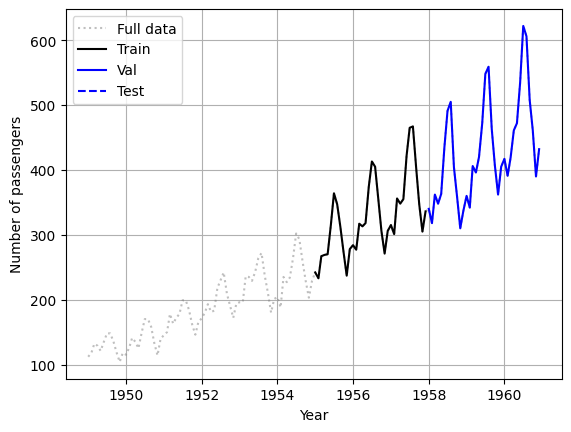

In [112]:
df = get_data()
train, val, test = train_val_test_split(df, [1955, 1958, 1965])

plt.xlabel('Year')
plt.ylabel('Number of passengers')

plt.plot(df, color='gray', alpha=0.5, linestyle='dotted', label='Full data')
plt.plot(train, color='k', label='Train')
plt.plot(val, color='b', label='Val')
plt.plot(test, color='b', linestyle='dashed', label='Test')

plt.grid()
plt.legend()
plt.show()

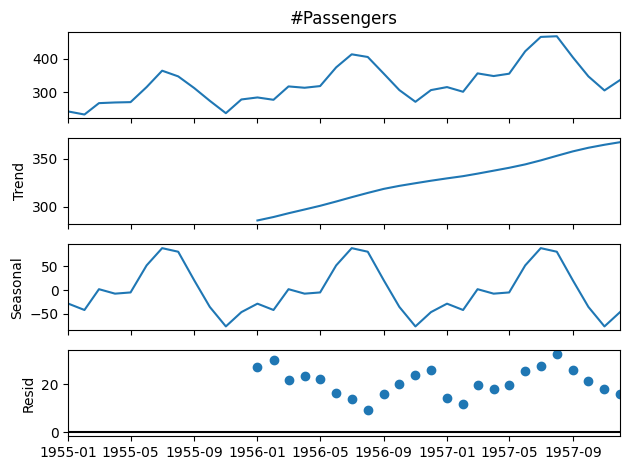

In [113]:
decompose = seasonal_decompose(train['#Passengers'], model='additive', period=12, two_sided=False)
decompose.plot()
plt.show()

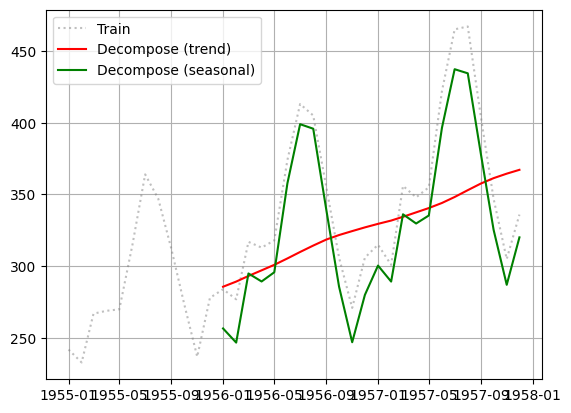

In [114]:
trend = decompose.trend.dropna()
seasonal = decompose.seasonal.dropna()

plt.plot(train, color='gray', linestyle='dotted', alpha=0.5, label='Train')
plt.plot(trend, color='r', label='Decompose (trend)')
plt.plot(trend + seasonal, color='g', label='Decompose (seasonal)')

plt.legend()
plt.grid()
plt.show()

In [115]:
X = np.arange(len(trend.values)).reshape(-1, 1)
y = trend.values

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.9949453637963709

In [116]:
print(reg.coef_)
print(reg.intercept_)

[3.45237319]
287.7230555555555


In [117]:
X_pred = np.arange(X[-1][0] + 1, X[-1][0] + len(val) + 1).reshape(-1, 1)
y_pred = reg.predict(X_pred)
y_pred = pd.Series(data=y_pred, index=val.index)

model_naive = y_pred + seasonal[- len(val):].values

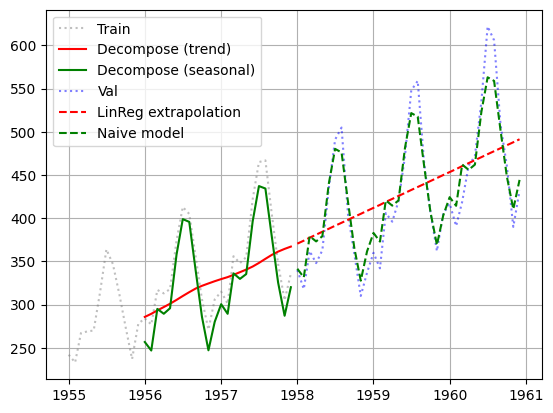

In [118]:
plt.plot(train, color='gray', linestyle='dotted', alpha=0.5, label='Train')
plt.plot(trend, color='r', label='Decompose (trend)')
plt.plot(trend + seasonal, color='g', label='Decompose (seasonal)')

plt.plot(val, color='blue', linestyle='dotted', alpha=0.5, label='Val')
plt.plot(y_pred, color='red', linestyle='dashed', label='LinReg extrapolation')
plt.plot(model_naive, color='green', linestyle='dashed', label='Naive model')

plt.legend()
plt.grid()
plt.show()

In [119]:
mean_absolute_error(val, model_naive)

17.161288412506707

In [120]:
np.sqrt(mean_squared_error(val, model_naive))

21.92894574516912